In [1]:
import os
import sys
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import platform
import numpy as np
import tensorflow as tf
import tensorflow.keras
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import h5py
import numpy as np
import pandas as pd

In [3]:
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")

Python Platform: Linux-5.19.0-45-generic-x86_64-with-glibc2.35
Tensor Flow Version: 2.12.1
Keras Version: 2.12.0

Python 3.8.19 (default, Apr  6 2024, 17:58:10) 
[GCC 11.4.0]


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
BASE_DIR = "/notebooks/data/LFWA+/COMPILED"
IMAGE_DIR = "/notebooks/data/LFWA+/COMPILED/compiled_lfwa+"
LIGH_PAIRS = "compiled_lfwa+_light_pairs.csv"
DARK_PAIRS = "compiled_lfwa+_dark_pairs.csv"
ALL_PAIRS = "compiled_lfwa+_all_pairs.csv"

In [7]:
all_pairs =  pd.read_csv("{}/{}".format(BASE_DIR, ALL_PAIRS))

In [8]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import VGG16

In [9]:
vgg16_model_base = VGG16(weights='imagenet', input_shape=(224, 224, 3))

# set VGG to be frozen
for layer in vgg16_model_base.layers:
    layer.trainable = False

In [10]:
vgg16_model = Model(
    inputs = vgg16_model_base.input, 
    outputs = vgg16_model_base.get_layer('fc2').output,
    name = "VGG16"
)

In [11]:
vgg19_model_base = VGG19(weights='imagenet', input_shape=(224, 224, 3))

# set VGG to be frozen
for layer in vgg19_model_base.layers:
    layer.trainable = False

In [12]:
vgg19_model = Model(
    inputs = vgg19_model_base.input, 
    outputs = vgg19_model_base.get_layer('fc2').output,
    name = "VGG19"
)

In [13]:
from BiasStudy import PredictionMetrics, PredictionResults, PredictionToolKit, PredictionPlotKit

In [14]:
vgg16_prediction_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = vgg16_model,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [15]:
vgg19_prediction_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = vgg19_model,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [16]:
print(vgg16_prediction_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 48.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.538990992714583 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.660708977407848 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.327586206896552 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.120689655172414 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 24.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.538990992714583 |
+-------

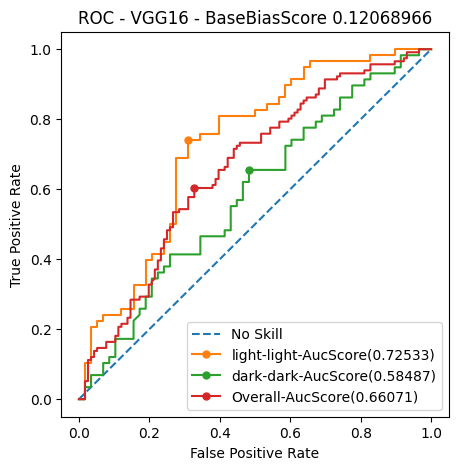

In [17]:
PredictionPlotKit.plot_roc(vgg16_prediction_result)

In [18]:
print(vgg19_prediction_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 50.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.526794362756123 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.678767835909631 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.206896551724138 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.137931034482759 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 28.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.528848210869629 |
+-------

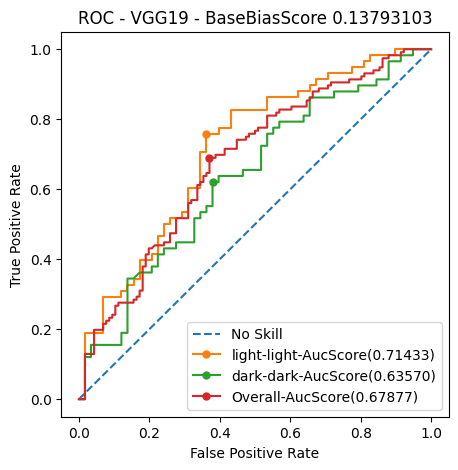

In [19]:
PredictionPlotKit.plot_roc(vgg19_prediction_result)

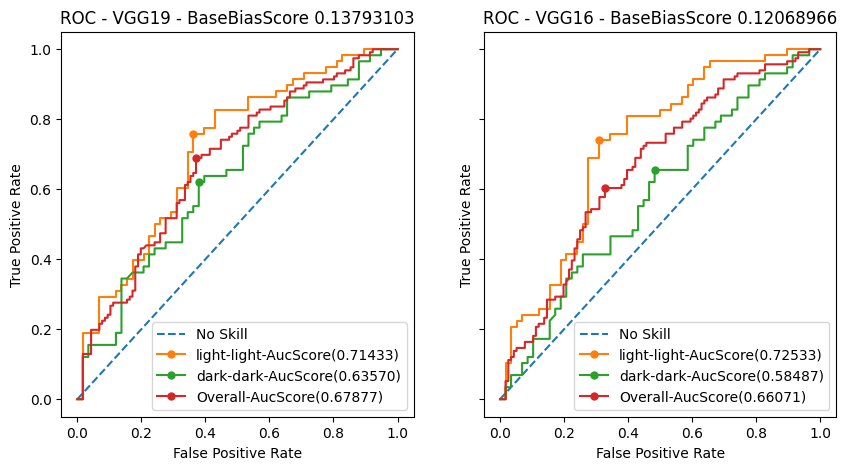

In [20]:
PredictionPlotKit.plot_multiple_roc(
    [
        vgg19_prediction_result,
        vgg16_prediction_result
    ]
)

In [21]:
from importlib.machinery import SourceFileLoader
resnet = SourceFileLoader("resnet","./resnet50_vggface/resnet.py").load_module()

weight_decay = 1e-4

# Code from https://github.com/WeidiXie/Keras-VGGFace2-ResNet50/tree/69a608a2a140b7025bcb69adcd2355e38cc89f1d
def Vggface2_ResNet50(input_dim=(224, 224, 3)):
    # inputs are of size 224 x 224 x 3
    inputs = keras.layers.Input(shape=input_dim, name='base_input')
    x = resnet.resnet50_backend(inputs)

    # AvgPooling
    x = keras.layers.AveragePooling2D((7, 7), name='avg_pool')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(512, activation='relu', name='dim_proj')(x)
    y = keras.layers.Lambda(lambda x: keras.backend.l2_normalize(x, 1))(x)

    # Compile
    model = keras.models.Model(inputs=inputs, outputs=y, name='ResNet50')
    opt = Adam()
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    return model

path_to_weights = "./resnet50_vggface/weights.h5"
model_resnet = Vggface2_ResNet50()
model_resnet.load_weights(path_to_weights, by_name=True)

In [22]:
resnet_prediction_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = model_resnet,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [23]:
print(resnet_prediction_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 24.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.579471009172599 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.833865933412604 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.275862068965517 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.068965517241379 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 10.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.597616325545456 |
+-------

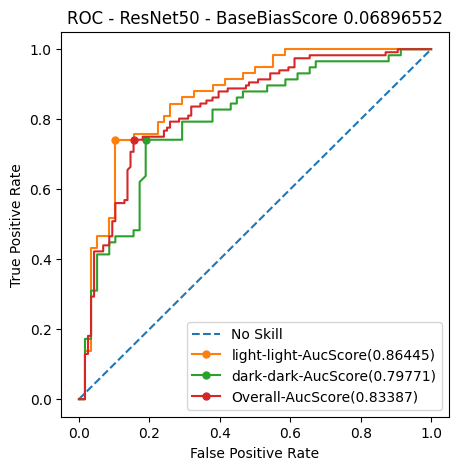

In [24]:
PredictionPlotKit.plot_roc(resnet_prediction_result)

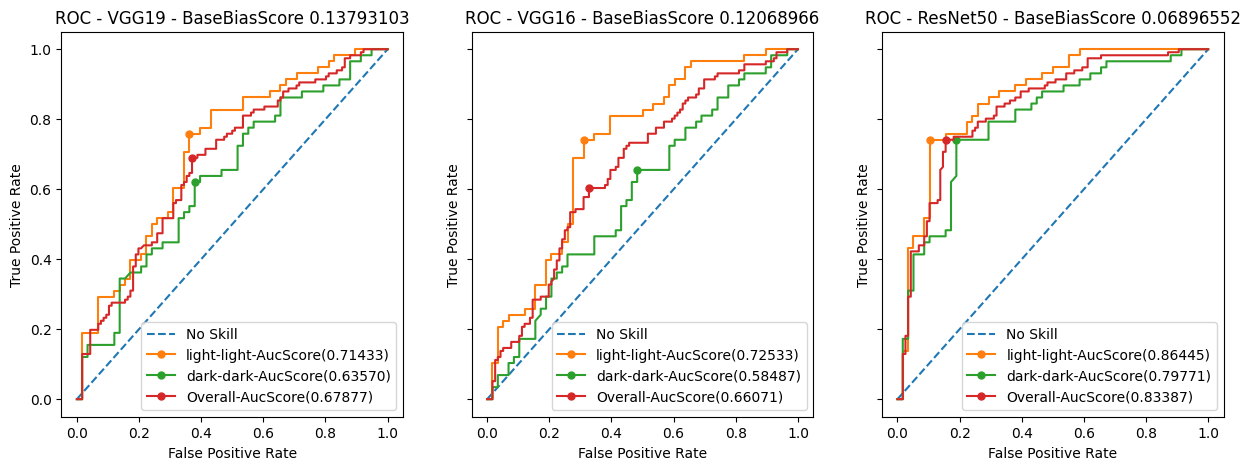

In [25]:
PredictionPlotKit.plot_multiple_roc(
    [
        vgg19_prediction_result,
        vgg16_prediction_result,
        resnet_prediction_result
    ]
)